# This code implements a simple Bayesian forward model for a hypothetical electron spectrometer with simple Gaussian response functions. The energy channel middles and widths are taken from the MagEIS LOW detector.

# The difference between this notebook and the one prior is this one expores the posterior distribution assuming multiple observations of the same energy spectra were made. 

Overall, this code creates the fake population and observed counts from a spectra specified by the user for validation purposes. Then the model conists of specifing the prior which is taken to be uniform distributions of  E0  and  J0 . The likeleyhood is then the integral of the sampled spectra folded through the instrument response.

Since there are 7 energy channels, I've had to specify the folding step into a function in order for this model to work in pymc3.

The Gaussain instrument response for the spectrometer (loosely based on MagEIS) is found in mageis_response.py

The code was inspired by Isaac Michaud ijmichau@ncsu.edu.

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Set this true if you want the plots saved.
save_plots = True

if save_plots:
    from datetime import datetime
    import os
    
    plotDir = '../plots/{}'.format(datetime.now().date())
    if not os.path.exists(plotDir):
        os.makedirs(plotDir)
        print('Made plotting directory: {}'.format(plotDir))

Made plotting directory: ../plots/2018-06-17


### Make a fake spectra and get the true counts. Then draw the "observed" counts assuming a Poisson process.

In [3]:
# Spectra parameters
E0t = 100
J0t = 200 

# Reponse parameters
R0 = 1e-2

# Number of observations made
n_obs = 3

# Energy array to descritize the spectra and response function
Earr = np.linspace(1, 300, num=1000) 
dE = Earr[1] - Earr[0] # To do the integral.

# Initialize the response function
R = mageis_response.R_gaus()

def spectra(Earr, J0, E0):
    return(J0*np.exp(-Earr/E0))

def true_spectra(Earr, J0t, E0t):
    return spectra(Earr, J0t, E0t)

# Now create the "true" counts drawn from the parent distribution. This assumes there
# is no uncertanity.
true_lambda = np.nan*np.zeros(7)
for i in range(7):
    true_lambda[i] = dE*np.dot(true_spectra(Earr, J0t, E0t), 
                               R.response(R0=R0, Earr=Earr, ch=i))

Visualize the "true" spectra as well as the instrument response functions.

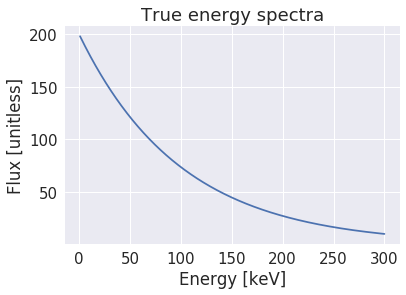

In [4]:
plt.plot(Earr, true_spectra(Earr, J0t, E0t)); plt.title('True energy spectra');
plt.ylabel('Flux [unitless]'); plt.xlabel('Energy [keV]');
if save_plots:
    plt.savefig('{}/true_spectra.png'.format(plotDir), dpi=300)

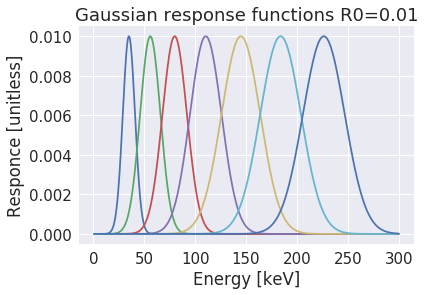

In [5]:
for i in range(7):
    plt.plot(Earr, R.response(R0=R0, Earr=Earr, ch=i))
plt.title('Gaussian response functions R0={}'.format(R0)); 
plt.ylabel('Responce [unitless]'); plt.xlabel('Energy [keV]');
if save_plots:
    plt.savefig('{}/response_functions.png'.format(plotDir), dpi=300)

Now add realism by drawing n_obs observed counts from true_lambda assuming a Poisson process

In [6]:
np.random.seed(123) # For reproducability.
c_obs = np.random.poisson(np.repeat(true_lambda[:, np.newaxis].T, n_obs, axis=0))

In [7]:
c_obs

array([[24, 24, 31, 26, 20, 15, 10],
       [16, 29, 29, 30, 26, 14,  9],
       [14, 28, 26, 25, 33, 18,  9]])

Visualize the counts derived from the spectra without uncertainty, and the counts that could have been observed if we assume a poisson process

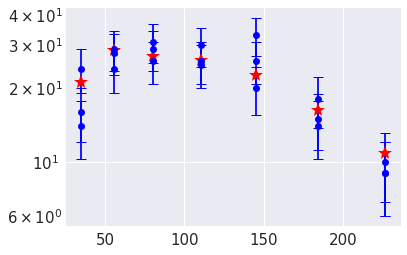

In [8]:
for cc in c_obs:
    (_, caps, _) = plt.errorbar(R.mu, cc, yerr=np.sqrt(cc), c='b', fmt='o', 
                                label='Observed counts', capsize=5)
    for cap in caps:
        cap.set_markeredgewidth(1)
    
plt.plot(R.mu, true_lambda, 'r*', ms=15, label=r'$\lambda$ population')
plt.yscale('log'); #plt.legend();
if save_plots:
    plt.savefig('{}/population_multiple_counts.png'.format(plotDir), dpi=300)

Sanity check: c_obs counts are drawn from lambda counts.

# Bayes model


In [9]:
m = pm.Model()

def lam(J):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the 7 instrument response functions.
    """
    lams = 7*[None]
    for i in range(c_obs.shape[1]):
        lams[i] = pm.Deterministic(
            'lam{}'.format(i),
            dE*pm.math.dot(J, R.response(R0=R0, Earr=Earr, ch=i))
                              )
    return lams

with m:
    # Prior stocastic variables
    J0 = pm.Uniform('J0', lower=1, upper=1E6)
    E0 = pm.Uniform('E0', lower=1, upper=500)
    
    # Define an exponential spectra
    J = J0*pm.math.exp(-Earr/E0)
    
    lams = lam(J)
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=c_obs.shape)
    trace = pm.sample(1E4, tuning=3000, cores=3)

KeyboardInterrupt: 

In [ ]:
pm.traceplot(trace, combined=True);
if save_plots:
    plt.savefig('{}/traceplot.png'.format(plotDir), dpi=300)

In [ ]:
pm.summary(trace)

In [ ]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(len(true_lambda))]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(len(true_lambda))]
c_Err = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
                    for i in range(len(true_lambda))])
c_Err

Now plot the observed counts vs the counts derived from the posterior

Brian's method

In [ ]:
plt.errorbar(R.mu, c_mean, yerr=c_Err.T, c='r', label='Modeled counts'); 
for cc in c_obs:
    plt.errorbar(R.mu, cc, yerr=np.sqrt(cc), c='b', label='Observed counts'); 
plt.yscale('log'); plt.legend();
if save_plots:
    plt.savefig('{}/modeleted_and_observed_counts_bl.png'.format(plotDir), dpi=300)

My method

In [ ]:
(_, caps, _) = plt.errorbar(R.mu, c_mean, yerr=np.sqrt(c_mean), c='r', fmt='o', 
                            capsize=10, label='Modeled counts'); 
for cap in caps:
    cap.set_markeredgewidth(1)
for cc in c_obs:
    (_, caps, _) = plt.errorbar(R.mu, cc, yerr=np.sqrt(cc), c='b', fmt='o',
                                label='Observed counts', capsize=5); 
    for cap in caps:
        cap.set_markeredgewidth(1)
    
plt.yscale('log'); plt.legend();
if save_plots:
    plt.savefig('{}/modeleted_and_observed_counts_ms.png'.format(plotDir), dpi=300)

In [ ]:
plt.scatter(trace['J0'], trace['E0'], marker='.');
if save_plots:
    plt.savefig('{}/posterior_scatter.png'.format(plotDir), dpi=300)

In [ ]:
sns.jointplot(trace['J0'], trace['E0']);

In [ ]:
plt.hist(trace['J0']); print('True value is', J0t)
if save_plots:
    plt.savefig('{}/J0_posterior.png'.format(plotDir), dpi=300)

In [ ]:
sns.distplot(trace['J0']);

In [ ]:
plt.hist(trace['E0']); print('True value is', E0t)
if save_plots:
    plt.savefig('{}/E0_posterior.png'.format(plotDir), dpi=300)

## Posterior post predictive checks
Here we draw samples from the posterior distribution and check if the calculated counts from the picked E0 and J0 values are consistant with the data. Essentialy, we are looking to see if the observed counts are inside the drawn posterior distribution. 

In [ ]:
ppc = pm.sample_ppc(trace, samples=2000, model=m)

In [ ]:
ppc.keys()

In [ ]:
c_obs

In [ ]:
ppc['c_m'].shape

In [ ]:
fig, ax = plt.subplots(7,1, figsize=(7,14))
for i in range(c_obs.shape[1]):
    for j in range(c_obs.shape[0]):
        ax[i].axvline(c_obs[j, i], c='r', lw=4)
    ax[i].hist(ppc['c_m'][:, :, i].flatten())
    
if save_plots:
    plt.savefig('{}/posterior_checks.png'.format(plotDir), dpi=300)

It appears that the observed counts are more or less centered on the sampled posterior distribution. This validates our posterior, and confirms that draws from it represents the data.

## Statistics of the J0 and E0 distributions that are consistant with the observed counts 
Now we calculate the statistics of 100 spectra drawn from the trace (mean, median, 2.5%, and 95% credible interval) as a function of energy

Pick 100 random draws of E0 and J0 from the trace, and calculate the statistics on those draws as a function of energy.

In [ ]:
nS = 100
random_samples = np.random.randint(0, len(trace), nS)
dist = np.zeros((len(Earr), nS), dtype=float)
for (i, s) in enumerate(random_samples):
    for e in range(len(Earr)):
        dist[e, i] = true_spectra(Earr, trace['J0'][s], trace['E0'][s])[e]

In [ ]:
for i in random_samples:
    plt.plot(Earr, true_spectra(Earr, trace['J0'][i], trace['E0'][i]), c='k', alpha=0.07)
plt.plot(Earr, np.mean(dist, axis=1), label='mean');
plt.plot(Earr, np.median(dist, axis=1), label='median');
plt.plot(Earr, np.percentile(dist, 2.5, axis=1), '--', label='2.5 percentile')
plt.plot(Earr, np.percentile(dist, 97.5, axis=1), '--', label='97.5 percentile', c='c')
plt.legend(); plt.yscale('log'); plt.ylabel('Flux [unitless]');
plt.xlabel('Energy [keV]'); plt.title('95% credible interval | exponential spectra');
if save_plots:
    plt.savefig('{}/spectra_credible_interval.png'.format(plotDir), dpi=300)